In [ ]:
import torch
import pickle
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.checkpoint

from PIL import Image
from torch.hub import load
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.nn import Conv2d
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
#Define types of DinoV2 models
dino_backbones = {
    'dinov2_b':{
        'name':'dinov2_vitb14',
        'embedding_size':768,
        'patch_size':14
    },
    'dinov2_g':{
        'name':'dinov2_vitg14',
        'embedding_size':1536,
        'patch_size':14
    },
}


class linear_head(nn.Module):
    def __init__(self, embedding_size = 384, num_classes = 1):
        super(linear_head, self).__init__()
        self.fc = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        return self.fc(x)


class conv_head(nn.Module):
    def __init__(self, embedding_size = 384, num_classes = 1):
        super(conv_head, self).__init__()
        self.segmentation_conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(embedding_size, 224, (3,3), padding=(1,1)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(224, num_classes, (3,3), padding=(1,1)),
        )

    def forward(self, x):
        x = self.segmentation_conv(x)
        #x = torch.sigmoid(x)
        return x

class Segmentor(nn.Module):
    def __init__(self, num_classes, backbone = 'dinov2_g', head = 'conv', backbones = dino_backbones):
        super(Segmentor, self).__init__()
        self.heads = {
            'conv':conv_head
        }
        self.backbones = dino_backbones
        self.backbone = load('facebookresearch/dinov2', self.backbones[backbone]['name'])
        self.backbone.eval()
        self.num_classes =  num_classes # add a class for background if needed
        self.embedding_size = self.backbones[backbone]['embedding_size']
        self.patch_size = self.backbones[backbone]['patch_size']
        self.head = self.heads[head](self.embedding_size,self.num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        mask_dim = (x.shape[2] / self.patch_size, x.shape[3] / self.patch_size) 
        with torch.no_grad():
            x = self.backbone.forward_features(x)
            x = x['x_norm_patchtokens']
            x = x.permute(0,2,1)
            x = x.reshape(batch_size,self.embedding_size,int(mask_dim[0]),int(mask_dim[1]))
        x = self.head(x)
        return x

In [3]:
# Load the image from the .pkl file
with open('128px_images.pkl', 'rb') as file:
    images = pickle.load(file)
    
with open('128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)
    
# Path to the saved model weights
model_weights = "dinov2_vitb14_linear_head.pth"

# List of class labels
classes = ['Mangrove']

# Number of classes
num_classes = len(classes)

TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
# define the number of channels in the input, number of classes,
# and number of levels in the model
NUM_CHANNELS = 9
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.00001
NUM_EPOCHS = 1
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 224 
INPUT_IMAGE_HEIGHT = 224
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the model
model = Segmentor(num_classes)
model.backbone.patch_embed.proj = Conv2d(9, 1536, kernel_size=(14, 14), stride=(14, 14))
model = model.to(DEVICE)
optimizer = Adam(model.parameters(), lr=0.0000001)
criterion = torch.nn.BCEWithLogitsLoss()

Using cache found in /home/jyang/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [4]:
class SegmentationDataset(Dataset):
  def __init__(self, images, labels, transforms, labelTransform):
    # store the image and mask filepaths, and augmentation
    # transforms
    self.transforms = transforms
    self.images = images
    self.labels = labels
    self.labelTransform = labelTransform
    
    #Check if the label and images are the same size
    if len(images) != len(labels):
        print(images.shape, labels.shape)
        raise ValueError("shapes aren't the same")
  def __len__(self):
    # return the number of total samples contained in the dataset
    return np.array(self.images).shape[0]
  def __getitem__(self, idx):
    try:
      image = self.images[idx]
      mask = self.labels[idx]
    except:
      raise ("no index at", idx)
    # load the image from disk, resize,
    # and read the associated mask from disk in grayscale mode
    # check to see if we are applying any transformations
    
    if self.transforms is not None:
      # apply the transformations to both image and its mask
        image = self.transforms(image)
        mask = self.labelTransform(mask)
    
    # return a tuple of the image and its mask
    return (image, mask)
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(images, labels, #images, labels,
                         test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# define transformations
transforms_image = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 ])
transforms_label = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize((64,
                                                    64)),
                                 ])
resize = transforms.Compose([
                                 
                                 transforms.Resize((224,
                                                    224)),
                                 ])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = transforms_image, labelTransform = transforms_label)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = transforms_image, labelTransform = transforms_label)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=0)
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=0)

Using cache found in /Users/jason/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [5]:
#Trains the model
def train(model, train_loader, criterion, optimizer, epoch):
    #Set the model in training mode 
    model.train()
    loop = tqdm(train_loader, total=len(train_loader))
    #Initialize variables to track stats 
    running_loss = 0
    lossArr = []
    total_acc = 0

    for batch_idx, (data, target) in enumerate(loop):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)

        #Calculate loss
        output = output.squeeze()
        target = target.squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss = loss.item())
        
        #Calculate accuracy
        predicted = (output > 0.5).float()
        accuracy = pixelAcc(target, output)
        total_acc += accuracy
        
    #Calculate stats
    tloss.append([epoch, running_loss/len(train_loader)])
    tacc.append([epoch, total_acc/len(train_loader)])
    print(f'\nTrain set: Average loss: {running_loss/len(train_loader):.4f}')
    print(running_loss, len(train_loader))
    print(f'\nTrain set: mIOU Score: {total_acc/len(train_loader):.4f}')
    print(total_acc, len(train_loader))


def validation(model, criterion, valid_loader, epoch):
    model.eval()
    running_loss = 0
    lossArr = []
    total_acc = 0

    with torch.no_grad():
        loop = tqdm(valid_loader, total=len(valid_loader))
        for data, target in loop:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            #Calculate loss
            loss = criterion(output, target)
            running_loss += loss.item()
            lossArr.append([len(vloss)+1, running_loss/(len(vloss)+1)])
            
            #Accuracy calculations
            predicted = (output > 0.5).float()
            loop.set_postfix(loss = loss.item())
            accuracy = pixelAcc(target, output)
            total_acc += accuracy
     
    #Track stats for validation
    vloss.append([len(vloss)+1, running_loss/len(valid_loader)])
    vacc.append([len(vacc)+1, total_acc/len(valid_loader)])
    print(f'\nValidation set: Average loss: {running_loss/len(valid_loader):.4f}')
    print(running_loss, len(valid_loader))
    print(f'\nTrain set: mIOU Score: {total_acc/len(valid_loader):.4f}')
    print(total_acc, len(valid_loader))

#Calculates the pixelwise accuracy for the model
def pixelAcc(target, predicted):    
    sigmoid  = torch.nn.Sigmoid()
    predicted = (sigmoid(predicted) > 0.5).to(int)
    pixelAccuracy = ((torch.eq(target, predicted)).sum().item()) / (32*64*64)     
    return pixelAccuracy

  0%|          | 0/109 [00:00<?, ?it/s]/home/jyang/miniconda3/envs/MangroveML/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Epoch 1: 100%|██████████| 109/109 [03:19<00:00,  1.83s/it, loss=0.512]



Train set: Average loss: 0.6258
68.21662878990173 109

Train set: mIOU Score: 0.6420
69.98209381103516 109


100%|██████████| 20/20 [00:27<00:00,  1.39s/it, loss=0.52] 



Validation set: Average loss: 0.4766
9.531697899103165 20

Train set: mIOU Score: 0.8331
16.661399841308594 20
[[0, 0.6258406311000159]]
[[1, 0.4765848949551582]]
[[0, 0.6420375578994051]]
[[1, 0.8330699920654296]]


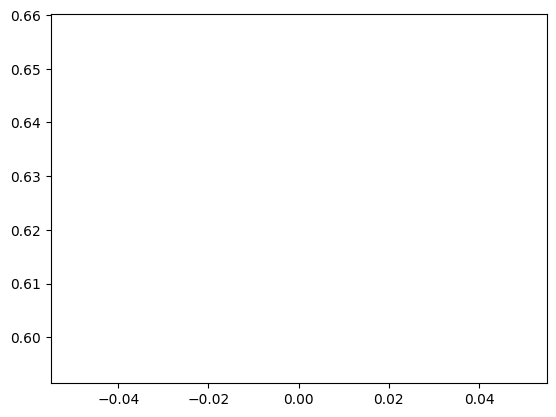

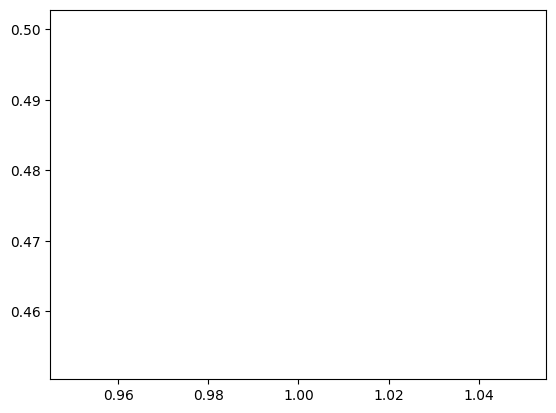

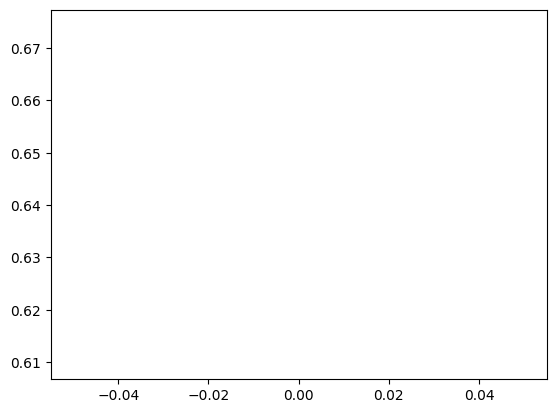

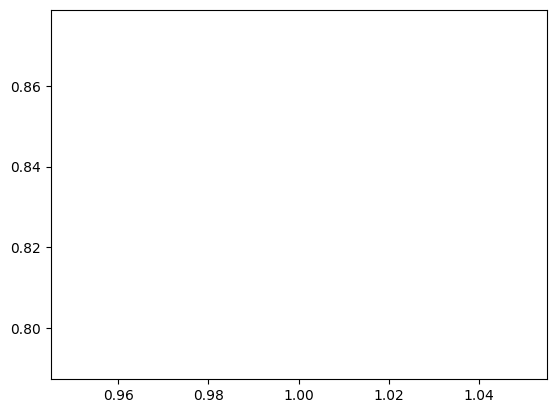

In [7]:
#Track the train/validation accuracy and loss 
tloss = []
vloss = []
tacc = []
vacc = []

for epoch in range(NUM_EPOCHS):
    train(model, trainLoader, criterion, optimizer, epoch)
    validation(model, criterion, testLoader, epoch)
    #Plot the train/test accuracy and loss every 10 epochs
    if epoch%10 == 0:
        print(tloss)
        print(vloss)
        print(tacc)
        print(vacc)
        xbatch, xloss = zip(*tloss)
        plt.plot(xbatch, xloss)
        plt.show()

        ybatch, yloss = zip(*vloss)
        plt.plot(ybatch, yloss)
        plt.show()

        abatch, aloss = zip(*tacc)
        plt.plot(abatch, aloss)
        plt.show()

        bbatch, bloss = zip(*vacc)
        plt.plot(bbatch, bloss)
        plt.show()



In [8]:
#Save the model
torch.save(model.state_dict(), 'weights/segmentation_model.pt')

shape
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.5000, 0.7500, 1.0000,  ..., 0.2500, 0.7500, 1.0000],
          [0.7500, 0.0000, 0.2500,  ..., 0.0000, 0.0000, 0.7500],
          [1.0000, 0.7500, 0.0000,  ..., 0.2500, 0.5000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2500, 0.5000],
          [0.0000, 0.0000, 0.0000,  ..., 0.7500, 0.2500, 0.2500],
          [0.0000, 0.0000, 0.0000,  ..., 0.2500, 1.0000, 0.7500]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 0.5000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.2500, 1.0000],
          [1.0000, 1.0000, 1.000

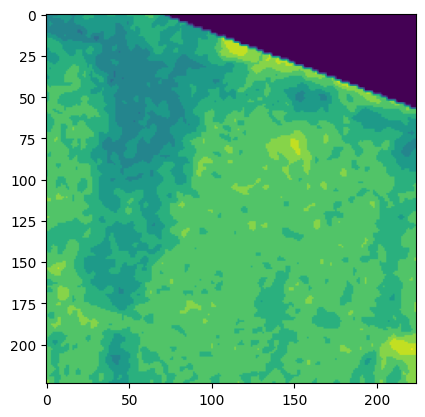

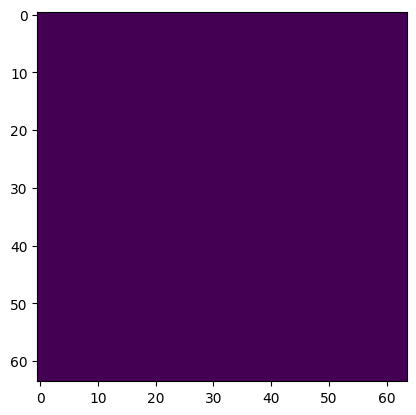

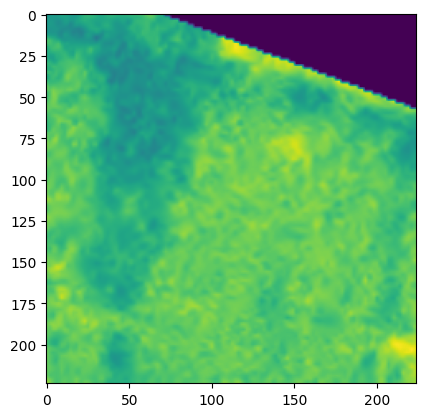

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [9]:
#Show an example mask 
# Display image and label.
train_features = next(iter(trainLoader))
img = train_features[0]
img = img[0:1, 0:3, :, :].squeeze()
maskimg = train_features[1]
#Print out the labels
print(maskimg)
maskimg = maskimg[0:1, :, :, :].squeeze()

# #slice 3D array into 2D arrays to be displayed 
channel_test =1
img_tensor = transforms.ToPILImage()(img)
img_tensor = transforms_image(img_tensor)

plt.imshow(img_tensor[channel_test, :, :])
plt.show()
plt.imshow(maskimg)
plt.show()

imgs = train_features[0]
imgs = imgs[0:1, :, :, :].squeeze()
imgs = resize(imgs)
oimgs = imgs.unsqueeze(0)

model.eval()
with torch.no_grad():
    # Make prediction
    output = model(oimgs)
    print("output")
    print(output)
    print(output.squeeze().shape, maskimg.shape)
    loss = criterion(output.squeeze(), maskimg)
    print(loss.item())
    # Get the predicted class for each pixel
    _, predicted = torch.max(output, 1,)
    print(predicted.shape)

# Move prediction to cpu and convert to numpy array
print(predicted)

In [ ]:
print(output.squeeze().size())
plt.imshow(img_tensor[channel_test, :, :])
plt.imshow(output.squeeze(), alpha=1)  # Overlay the mask on the image with transparency
plt.show()
plt.imshow(output.squeeze()[0, :, :])
plt.show()